In [1]:
# Step 1: Import required libraries
import pandas as pd
import numpy as np

# Step 2: Load the data
df = pd.read_csv("student_depression_dataset (1).csv")

# Step 3: Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(r'[ /?]', '_', regex=True).str.rstrip('_')

# Step 4: Convert categorical 'Yes/No' type values to 0/1
yes_no_columns = ['depression', 'have_you_ever_had_suicidal_thoughts', 'family_history_of_mental_illness']
for col in yes_no_columns:
    if df[col].dtype == object:
        df[col] = df[col].str.strip().str.lower().map({'yes': 1, 'no': 0})

# Step 5: Replace '?' and empty strings with NaN
df.replace(['?', ' '], np.nan, inplace=True)

# Step 6: Convert numerical columns to numeric (if some were read as object)
num_cols = ['age', 'cgpa', 'academic_pressure', 'study_satisfaction', 
            'job_satisfaction', 'work_study_hours', 'financial_stress']
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

# Step 7: Fill missing values (Median for numeric, Mode for categorical)
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# Step 8: Confirm no more missing values
print("Missing values after cleaning:")
print(df.isnull().sum())



Missing values after cleaning:
id                                     0
gender                                 0
age                                    0
city                                   0
profession                             0
academic_pressure                      0
work_pressure                          0
cgpa                                   0
study_satisfaction                     0
job_satisfaction                       0
sleep_duration                         0
dietary_habits                         0
degree                                 0
have_you_ever_had_suicidal_thoughts    0
work_study_hours                       0
financial_stress                       0
family_history_of_mental_illness       0
depression                             0
dtype: int64


In [3]:
# Step 1: Drop ID and unrelated features
df_model = df.drop(columns=['id', 'city'])

# Step 2: Define target and features
target = 'depression'
features = df_model.columns.drop(target)

X = df_model[features]
y = df_model[target]

# Check class balance of the target
print("Target variable distribution:")
print(y.value_counts(normalize=True))

Target variable distribution:
depression
1    0.585499
0    0.414501
Name: proportion, dtype: float64


In [5]:
# Step 3: One-Hot Encode Categorical Features
from sklearn.preprocessing import OneHotEncoder

# Get categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# One-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Show the new feature shape
print(f"Original features shape: {X.shape}")
print(f"Encoded features shape: {X_encoded.shape}")


Original features shape: (27901, 15)
Encoded features shape: (27901, 58)


In [7]:
#split the dataset into training and testing data sets

from sklearn.model_selection import train_test_split

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Check shapes
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (22320, 58)
Test set shape: (5581, 58)


In [9]:
#scale the features
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2313
           1       0.86      0.88      0.87      3268

    accuracy                           0.85      5581
   macro avg       0.84      0.84      0.84      5581
weighted avg       0.84      0.85      0.84      5581

Confusion Matrix:
[[1840  473]
 [ 392 2876]]
ROC AUC Score: 0.9179504540617371


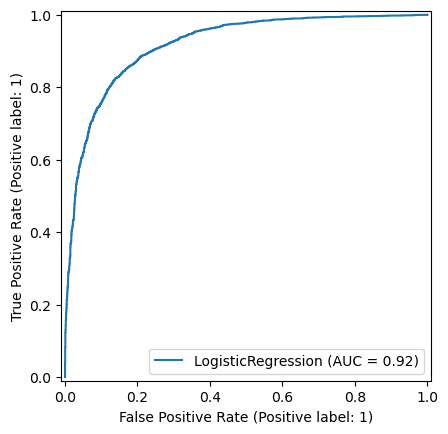

In [11]:
#Model 1
#Train and Evaluate Logistic Regression
#This model will help predict whether a student is depressed (1) or not (0)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Initialize and train the model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Plot ROC Curve
RocCurveDisplay.from_estimator(logreg, X_test_scaled, y_test)

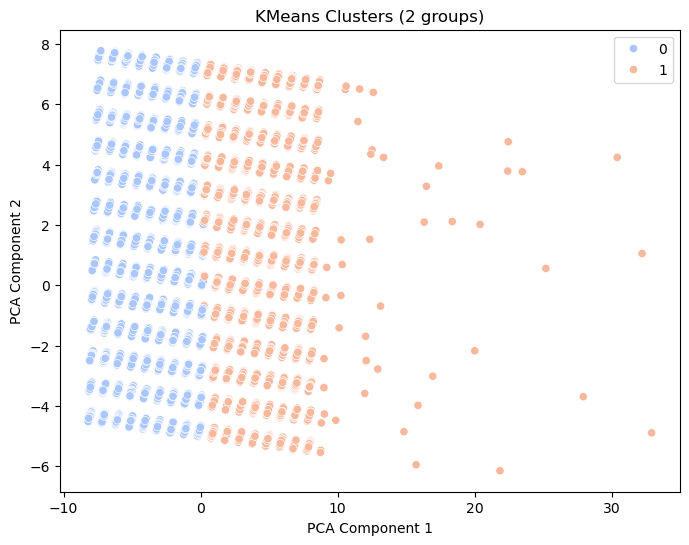

Adjusted Rand Index (ARI) vs true labels: 0.038038277296096004


In [13]:
#Model 2 KMeans

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Reduce dimensionality for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_encoded)

# Step 2: Apply KMeans 
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_encoded)

# Step 3: Visualize clusters using PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="coolwarm")
plt.title("KMeans Clusters (2 groups)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

# Step 4: Compare with actual depression labels
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y, clusters)
print("Adjusted Rand Index (ARI) vs true labels:", ari)

In [15]:
df_model.to_csv("cleaned_dataset.csv", index=False)

In [17]:
#hot encoding

import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned dataset
df = pd.read_csv("cleaned_dataset.csv")

# Drop ID and city 
df_model = df.drop(columns=['id', 'city'], errors='ignore')

# Define features and target
target = 'depression'
X = df_model.drop(columns=target)
y = df_model[target]

# One-hot encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split again for modeling
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Print confirmation
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (22320, 58)
X_test shape: (5581, 58)


Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      2313
           1       0.85      0.88      0.86      3268

    accuracy                           0.84      5581
   macro avg       0.83      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581

Confusion Matrix:
[[1802  511]
 [ 396 2872]]
ROC AUC Score: 0.9134511787718927


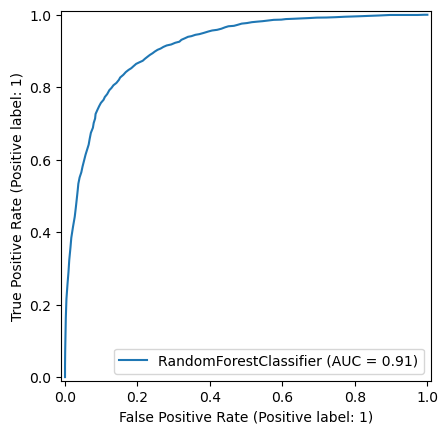

In [19]:
#Model 3: Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

roc_auc = roc_auc_score(y_test, y_proba_rf)
print("ROC AUC Score:", roc_auc)

# Plot ROC
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      2313
           1       0.85      0.89      0.87      3268

    accuracy                           0.84      5581
   macro avg       0.84      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581

Confusion Matrix:
[[1790  523]
 [ 374 2894]]
ROC AUC Score: 0.9168233696931981


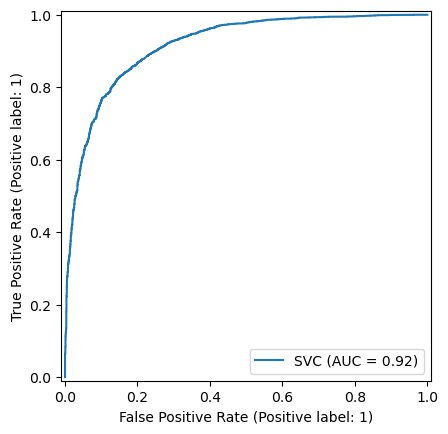

In [21]:
#Model 4: Support Vector Machine (SVM)

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM with probability estimates
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

roc_auc = roc_auc_score(y_test, y_proba_svm)
print("ROC AUC Score:", roc_auc)

# Plot ROC
RocCurveDisplay.from_estimator(svm_model, X_test_scaled, y_test)

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2313
           1       0.80      0.80      0.80      3268

    accuracy                           0.76      5581
   macro avg       0.76      0.76      0.76      5581
weighted avg       0.76      0.76      0.76      5581

Confusion Matrix:
[[1656  657]
 [ 659 2609]]
ROC AUC Score: 0.7571504603060453


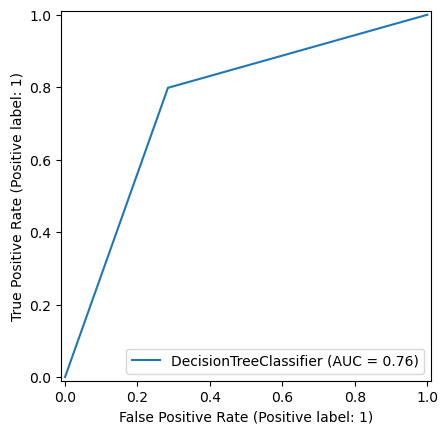

In [23]:
#model 5
#Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

roc_auc = roc_auc_score(y_test, y_proba_dt)
print("ROC AUC Score:", roc_auc)

# Plot ROC Curve
RocCurveDisplay.from_estimator(dt_model, X_test, y_test)


In [31]:
#hyperparameter tuning 
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("cleaned_dataset.csv")

# Separate features and target
X = df.drop(columns=["depression"])
y = df["depression"]

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models and hyperparameters
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [None, 10],
            "min_samples_split": [2, 5],
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1, 1],
            "penalty": ["l2"],
            "solver": ["liblinear"]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1],
            "kernel": ["linear", "rbf"]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "max_depth": [None, 5],
            "min_samples_split": [2, 5]
        }
    }
}

# Run GridSearchCV for all models
results = []

for name, config in models.items():
    print(f"Training and tuning: {name}")
    grid = GridSearchCV(config["model"], config["params"], cv=3, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


Training and tuning: RandomForest
Training and tuning: LogisticRegression
Training and tuning: SVM
Training and tuning: DecisionTree
                Model                                        Best Params  \
0        RandomForest  {'max_depth': 10, 'min_samples_split': 5, 'n_e...   
1  LogisticRegression  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...   
2                 SVM                       {'C': 1, 'kernel': 'linear'}   
3        DecisionTree           {'max_depth': 5, 'min_samples_split': 2}   

   Accuracy  Precision    Recall  F1 Score   ROC AUC  
0  0.831392   0.833963  0.885732  0.859068  0.907818  
1  0.839097   0.851986  0.874614  0.863151  0.914133  
2  0.838201   0.848820  0.877393  0.862870  0.913874  
3  0.812937   0.857329  0.812847  0.834496  0.885713  
